In [1]:
import os
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import pyvista as pv
pv.set_jupyter_backend('trame')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandas as pd
import time




Classe qui retourne un vecteur dataset où chaque élément correspond les données de chaque simulation. Les composantes du vecteur sont:
- La position des ddls (pos)
- Le stress de von mises sur chaque ddl (stress)
- Le vecteur de déplacement $( \mathbf{u} )$
- La norme euclidienne de $\| \mathbf{u} \|$


voici un element du vecteur dataset: (pos, stress, u, norme_u)




pour extraire le vecteur, utilisez simplement ces commandes:
   
   dossier = "nom_du_dossier"
   data = VTKDataset(dossier).dataset





In [2]:

class VTKDataset:
    def __init__(self, dossier):
        self.dossier = dossier
        self.dataset = self._create_dataset()

    def _listdir_vtu(self):
        """Liste les fichiers .vtu dans le dossier spécifié."""
        c = []
        for fichier in os.listdir(self.dossier):
            if fichier.endswith(".vtu"):
                c.append(os.path.join(self.dossier, fichier))
        return c

    def _extract_vtk_thermique(self, file_name):
        """Extrait les données thermiques d'un fichier .vtu."""
        reader = vtk.vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_name)
        reader.Update()

        # Position ddl
        nodes_vtk_array = reader.GetOutput().GetPoints().GetData()
        pos = vtk_to_numpy(nodes_vtk_array)

        #stress de von mises
        stress_vtk_array = reader.GetOutput().GetPointData().GetArray(0)
        stress = vtk_to_numpy(stress_vtk_array)

        # Norme de u
        norme_u = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(2))

        # u
        u = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(3))

        return pos, stress, u, norme_u

    def _create_dataset(self):
        """Crée le dataset en extrayant les données de tous les fichiers .vtu."""
        fichiers = self._listdir_vtu()
        dataset = []
        for fichier in fichiers:
            pos, stress, u, norme_u = self._extract_vtk_thermique(fichier)
            dataset.append((pos, stress, u, norme_u))
        return dataset


In [39]:
class analysis:
    '''
       Analyse de la simulation
    '''
    def __init__(self, dossier, niveau_confiance=0.95, niveau_stress_test=0.20):
        self.dataset = VTKDataset(dossier).dataset
        self.ddl = self.data_simulation(0)[2].shape[0] #nombre de ddl
        self.nb_sim = len(self.dataset)
        self.sigma_v = 0.35

        #position avant deformation 
        data = VTKDataset(dossier).dataset
        dataset = data[0] #premiere simulation
        self.pos = dataset[0]
        
        #statistic
        self.u_moyen, self.u_moyen_var, self.stress_moyen, self.stress_moyen_var = self._statistic()

        x = np.linalg.norm(self.u_moyen_var, axis=1) / (np.sqrt(self.nb_sim) * np.linalg.norm(self.u_moyen, axis=1))
        print(f'Le COV maximal est de :{np.nanmax(x)}')
        
        #affichage des tests d'hypotheses
        #self.affichage_tests(niveau_stress_test, niveau_confiance)

    def data_simulation(self, sim):
        '''
        sim: (type=int) la simulatiton que je veux 
        return dataset de la simulation demande (position, stress, deplacement, norme du deplacement)
        '''
        simulation = self.dataset[sim]
        pos, stress, u, norme_u = simulation[0], simulation[1], simulation[2], simulation[3] 
        return pos, stress, u, norme_u

    def _statistic(self):
        mean_x, mean_y, mean_z = [], [], []
        var_x, var_y, var_z = [], [], []
        
        mean_stress = []
        var_stress = []

        prob_deformation_permanante = []  
        for i in range(self.ddl): #pour chaque ddl
            x, y, z = np.zeros(self.nb_sim), np.zeros(self.nb_sim), np.zeros(self.nb_sim)
            stress = np.zeros(self.nb_sim)
            deformation_permanante = np.zeros(self.nb_sim) #return 1 si stress > sigma_v else 0
            for j in range(self.nb_sim): #pour chaque simulation
                u = self.data_simulation(j)[2][i] #deplacement en (x,y,z) au ddl i
                x[j], y[j], z[j] = u[0], u[1], u[2]

                stress_ddl = self.data_simulation(j)[1][i] #stress au ddl i
                stress[j] = stress_ddl
                deformation_permanante[j] = 1 if stress_ddl > 0.35 else 0
                
            #moyenne et variance deplacement a chaque ddl
            mean_x.append(np.mean(x)), mean_y.append(np.mean(y)), mean_z.append(np.mean(z))
            var_x.append(np.var(x, ddof=1)), var_y.append(np.var(y, ddof=1)), var_z.append(np.var(z, ddof=1))

            #moyenne et variance stress chaque ddl 
            mean_stress.append(np.mean(stress))
            var_stress.append(np.var(stress, ddof=1))

            #probabilite de deformation (deforme plus souvent que ne deforme pas mais ne prend pas en compte la moyenne juste
            #le nombre de deformation
            prob_deformation_permanante.append(np.mean(deformation_permanante))
             
        u_moyen = np.array([mean_x, mean_y, mean_z]).T
        var_moyen = np.array([var_x, var_y, var_z]).T
        return u_moyen, var_moyen, np.array(mean_stress), np.array(var_stress)


    def test_hypothese(self, x, confidence_lvl=0.95):
        """
        description: méthode qui calcul des tests d'hypothese selon la methode
        des percentiles et du bootstrap-t 
        
        confidence_lvl: type = int
               le niveau de confiance p(x < alpha) = confidence_lvl
        x: type = float
           Le niveau de stress minimum pour commencer a faire des test statistique sur les ddls
               
        return resultat_p, resultat_t 
               p pour test selon percentile et t pour test selon bootstrap-t
               type = dict
               la cle: represente le ddl en question
               valeur: 0 = pas de deformation permanante 
                       1 = deformation permanante
                       2 = ne peut pas conclure au niveau de confiance
        """
        alpha = 1-confidence_lvl
        
        
        #ddl critique a testé
        indice_test = np.where(self.stress_moyen >= x)[0]
        
        resultat_p = {} #test percentile
        resultat_t = {} #test bootstrap_t
        resultat_tt = {} #test bootstrap-t données transformées
        #1) tester si u_moyen < 0.35 à 95%
        for i in indice_test: #le ddl en question
            data = [] #sur des simulations sur le ddl i
            for j in range(self.nb_sim): #pour toutes les sim
                stress_ddl = self.data_simulation(j)[1][i] #stress au ddl i 
                data.append(stress_ddl)
            
            #fin de la generation du dataset sur le ddl i pour le bootstrap
            new_cfl = 1 - (1-confidence_lvl)*2
            bootstrap_data = bootstrap((data,), np.mean, n_resamples=2000, confidence_level=new_cfl)
            ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high
            
             #non deformation
            if ci_high < self.sigma_v:
                resultat_p[i] = 0
            else:
                #on ne peut pas conclure
                if ci_low < self.sigma_v:
                    resultat_p[i] = 2
                #deformation permanante
                else:
                    resultat_p[i] = 1

            #test bootstrap-t
            ci_low_t, ci_high_t = self.bootstrap_t(data,np.mean, 2000, alpha)  #bootstrap_t est la derniere methode de la classe

            #non deformation
            if ci_high_t < self.sigma_v:
                resultat_t[i] = 0
            else:
                #on ne peut pas conclure
                if ci_low_t < self.sigma_v:
                    resultat_t[i] = 2
                #deformation permanante
                else:
                    resultat_t[i] = 1

            """
            #bootstrap-t transformé
            ci_low_tt, ci_high_tt = self.bootstrap_t_transfo(data,np.mean, 2000, alpha)
            if ci_high_tt < self.sigma_v:
                resultat_tt[i] = 0
            else:
                #on ne peut pas conclure
                if ci_low_tt < self.sigma_v:
                    resultat_tt[i] = 2
                #deformation permanante
                else:
                    resultat_tt[i] = 1
            """        
          
        return resultat_p, resultat_t, resultat_tt
            


    def affichage_tests(self, x, confidence_lvl=0.95):
        
        dict_p, dict_t, dict_tt = self.test_hypothese(x, confidence_lvl)

        #test percentile 
        percentile = np.zeros(self.ddl) #vecteur ddl en ordre et valeur du tests
        for cle, valeur in dict_p.items():
            if valeur != 0:
                percentile[cle] = valeur

        #test bootstrap-t
        bs_t = np.zeros(self.ddl) #vecteur ddl en ordre et valeur du tests
        for cle, valeur in dict_t.items():
            if valeur != 0:
                bs_t[cle] = valeur

        '''
        #test bootstrap-t transfo
        bs_tt = np.zeros(self.ddl) #vecteur ddl en ordre et valeur du tests
        for cle, valeur in dict_tt.items():
            if valeur != 0:
                bs_tt[cle] = valeur
        '''
        #affichage percentile
        mesh_p = pv.PolyData(self.pos)
        mesh_p['percentile'] = percentile
        mesh_p.plot(scalars='percentile', cmap='plasma')

        #affichage boostrap-t
        mesh_t = pv.PolyData(self.pos)
        mesh_t['bootstrap-t'] = bs_t
        mesh_t.plot(scalars='bootstrap-t', cmap='plasma')

        '''
        #affichage boostrap-t
        mesh_t = pv.PolyData(self.pos)
        mesh_t['bootstrap-t avec transformation des données'] = bs_tt
        mesh_t.plot(scalars='bootstrap-t avec transformation des données', cmap='plasma')
        '''
    
    def bootstrap_t(self, data, func, n_resamples=1000, alpha=0.05):
        n = len(data)
        original_stat = func(data)
        bootstrap_stats = np.zeros(n_resamples)
        studentized_stats = np.zeros(n_resamples)

        # Calculer l'erreur standard de l'échantillon original
        original_std = np.std(data, ddof=1) / np.sqrt(n)

        for i in range(n_resamples):
            # Générer un échantillon bootstrap
            bootstrap_sample = np.random.choice(data, size=n, replace=True)
            # Calculer la statistique de l'échantillon bootstrap
            bootstrap_stat = func(bootstrap_sample)
            # Calculer l'erreur standard bootstrap
            bootstrap_std = np.std(bootstrap_sample) / np.sqrt(n)  #formule analytique plug-in
            # Calculer la statistique studentisée
            studentized_stats[i] = (bootstrap_stat - original_stat) / bootstrap_std
           
        #plt.hist(studentized_stats, bins=50)
        #plt.show()
        # Calculer les quantiles pour l'intervalle de confiance
        lower_quantile = np.percentile(studentized_stats, 100 * alpha )
        upper_quantile = np.percentile(studentized_stats, 100 * (1 - alpha))
        ci_lower = original_stat - upper_quantile * original_std
        ci_upper = original_stat - lower_quantile * original_std
    
        return ci_lower, ci_upper



    def bootstrap_t_transfo(self, data, func, n_resamples=1000, alpha=0.05):
        '''
        applique le bootstrap-t mais transforme les données pour corrigées le skewness. 
        La transformation est : x -> (x)^(1/2)

        return:  Interval de confiance
        '''
         
        data = np.sqrt(data) #transformation des données
        n = len(data)
        original_stat = func(data)
        bootstrap_stats = np.zeros(n_resamples)
        studentized_stats = np.zeros(n_resamples)
         
        for i in range(n_resamples):
            # Générer un échantillon bootstrap
            bootstrap_sample = np.random.choice(data, size=n, replace=True)
            # Calculer la statistique de l'échantillon bootstrap
            bootstrap_stat = func(bootstrap_sample)
            # Calculer la statistique studentisée
            studentized_stats[i] = bootstrap_stat - original_stat
           
        
        # Calculer les quantiles pour l'intervalle de confiance
        lower_quantile = np.percentile(studentized_stats, 100 * alpha )
        upper_quantile = np.percentile(studentized_stats, 100 * (1 - alpha))
        ci_lower = original_stat - upper_quantile * original_std
        ci_upper = original_stat - lower_quantile * original_std
        return ci_lower ** 2, ci_upper ** 2
  
    

    

In [40]:
dossier = r"C:\Users\Samuel\giref\3D\100_VonMises"
test = analysis(dossier, 0.90)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_22600\3120340254.py:19: RuntimeWarning: invalid value encountered in divide
  x = np.linalg.norm(self.u_moyen_var, axis=1) / (np.sqrt(self.nb_sim) * np.linalg.norm(self.u_moyen, axis=1))


Le COV maximal est de :0.010441720605674084


In [41]:
#solution moyenne
pos, u_moyen = test.pos, test.u_moyen
mesh_p = pv.PolyData(pos + u_moyen)
mesh_p['Déplacement moyen'] = u_moyen
mesh_p.plot(scalars='Déplacement moyen', cmap='plasma')

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1bae2d51430_13&reconnect=auto" class="pyvi…

In [42]:
#variance de la solutionu moyenne
var = test.u_moyen_var
mesh_p = pv.PolyData(pos)
mesh_p['Variance du déplacement'] = var
mesh_p.plot(scalars='Variance du déplacement', cmap='plasma')

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1baf0d8eb80_14&reconnect=auto" class="pyvi…

In [43]:
#stress de von mises sans interval de confiance
stress = test.stress_moyen
mesh_p = pv.PolyData(pos)
mesh_p['Stress de von Mises moyen'] = stress
mesh_p.plot(scalars='Stress de von Mises moyen', cmap='plasma')

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1baf0b49100_15&reconnect=auto" class="pyvi…

Je vais afficher les distributions échantillonnales du stress de von Mises ainsi qu'une approximation de la distribution bootstrap de la moyenne échantillonnales pour 10 000 rééchantillons, pour certains DDL d'intérêt.

In [47]:
p, t, x = test.test_hypothese(0.20)

Graphique enregistré sous 'C:\Users\Samuel\Downloads\échantillon_stress.png'


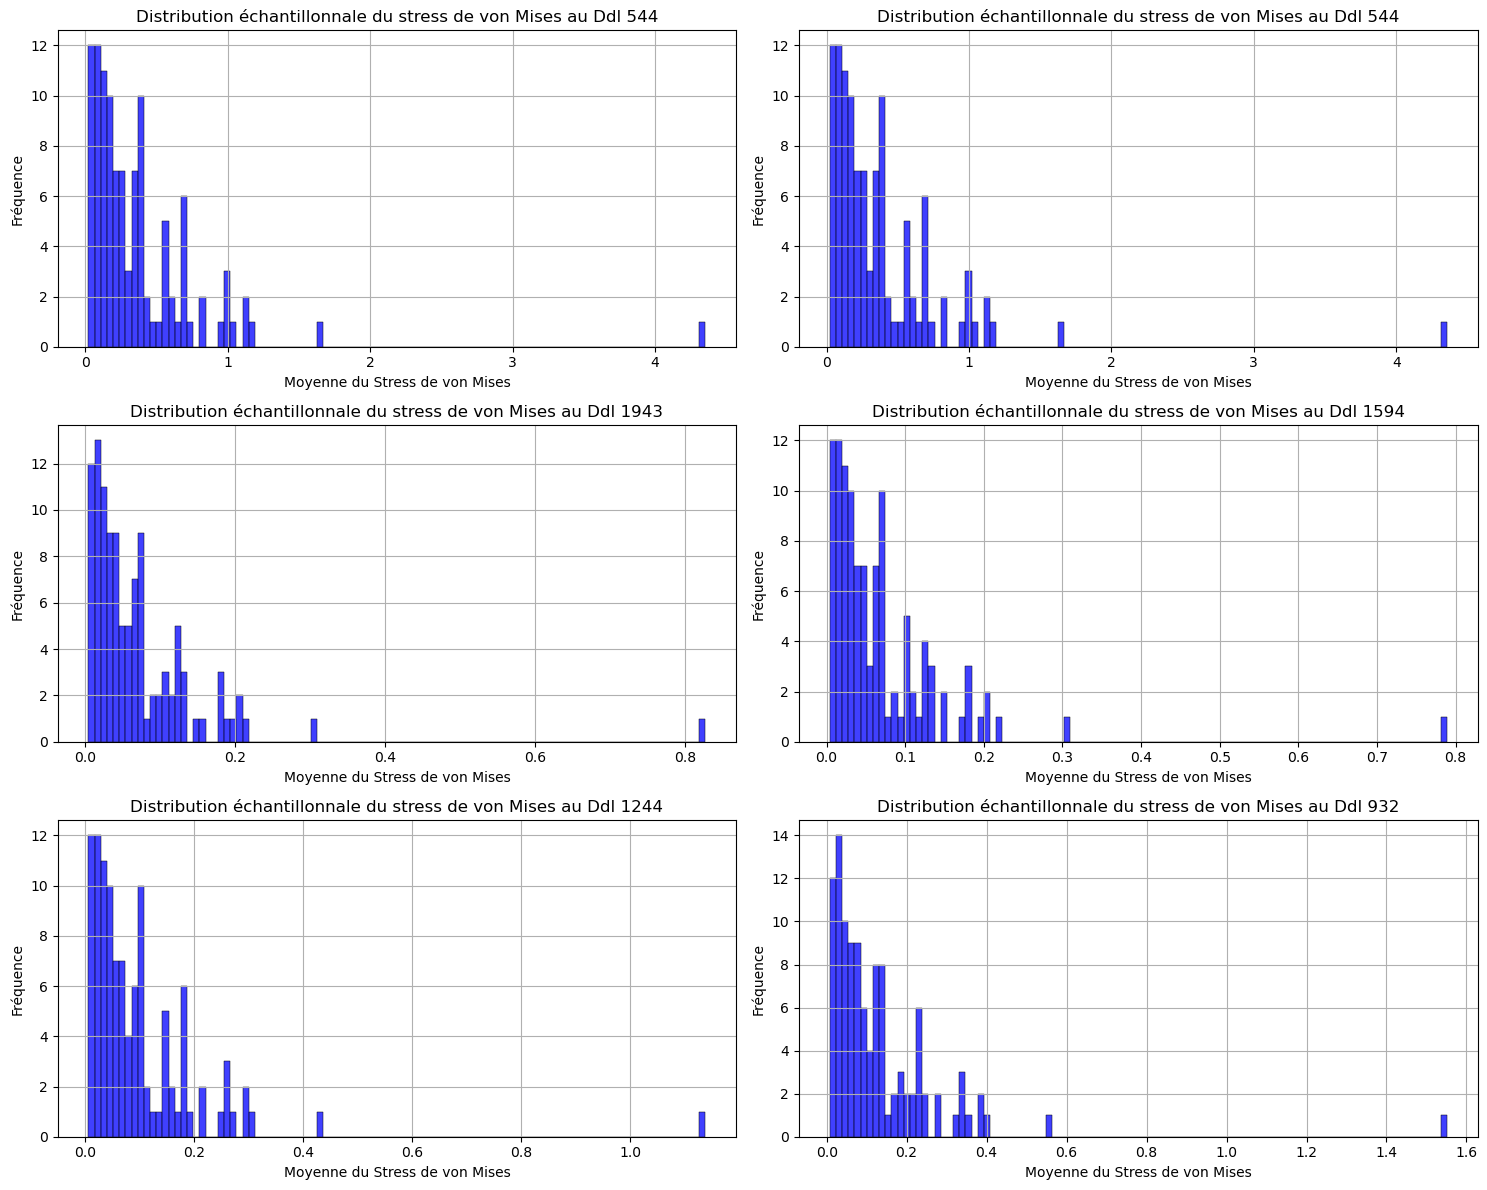

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Variables simulées (à remplacer par tes propres données)
stress_moyen = test.stress_moyen
stress_moyen_var = test.stress_moyen_var

# Calcul des indices des valeurs maximales, médianes et moyennes
indice_max_stress_moyen = np.argmax(stress_moyen)
indice_max_stress_moyen_var = np.argmax(stress_moyen_var)
indice_median_stress_moyen = np.abs(stress_moyen - np.median(stress_moyen)).argmin()
indice_median_stress_moyen_var = np.abs(stress_moyen_var - np.median(stress_moyen_var)).argmin()
indice_moyenne_stress_moyen = np.abs(stress_moyen - np.mean(stress_moyen)).argmin()
indice_moyenne_stress_moyen_var = np.abs(stress_moyen_var - np.mean(stress_moyen_var)).argmin()

# Stocker tous les indices dans une liste
liste_indices = [
    indice_max_stress_moyen, 
    indice_max_stress_moyen_var, 
    indice_median_stress_moyen, 
    indice_median_stress_moyen_var, 
    indice_moyenne_stress_moyen, 
    indice_moyenne_stress_moyen_var
]

# Créer une figure avec 5 sous-graphes
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 lignes, 2 colonnes de sous-graphiques
axes = axes.flatten()  # Transformer en un tableau 1D pour itérer plus facilement

# Parcourir les indices et générer les graphiques bootstrap pour chacun
for idx, i in enumerate(liste_indices):
    data = []  # Pour collecter les stress sur les simulations pour le ddl i
    for j in range(test.nb_sim):  # Pour toutes les simulations
        stress_ddl = test.data_simulation(j)[1][i]  # Stress au ddl i 
        data.append(stress_ddl)


    # Visualiser la distribution bootstrap des moyennes
    sns.histplot(data, bins=100, color='blue', ax=axes[idx])
    axes[idx].set_title(f'Distribution échantillonnale du stress de von Mises au Ddl {i}')
    axes[idx].set_xlabel('Moyenne du Stress de von Mises')
    axes[idx].set_ylabel('Fréquence')
    axes[idx].grid(True)

# Ajuster l'affichage des sous-graphes
plt.tight_layout()
downloads_folder = os.path.join(os.path.expanduser('~'), 'Downloads')
file_path = os.path.join(downloads_folder, 'échantillon_stress.png')
plt.savefig(file_path)
print(f"Graphique enregistré sous '{file_path}'")
plt.show()

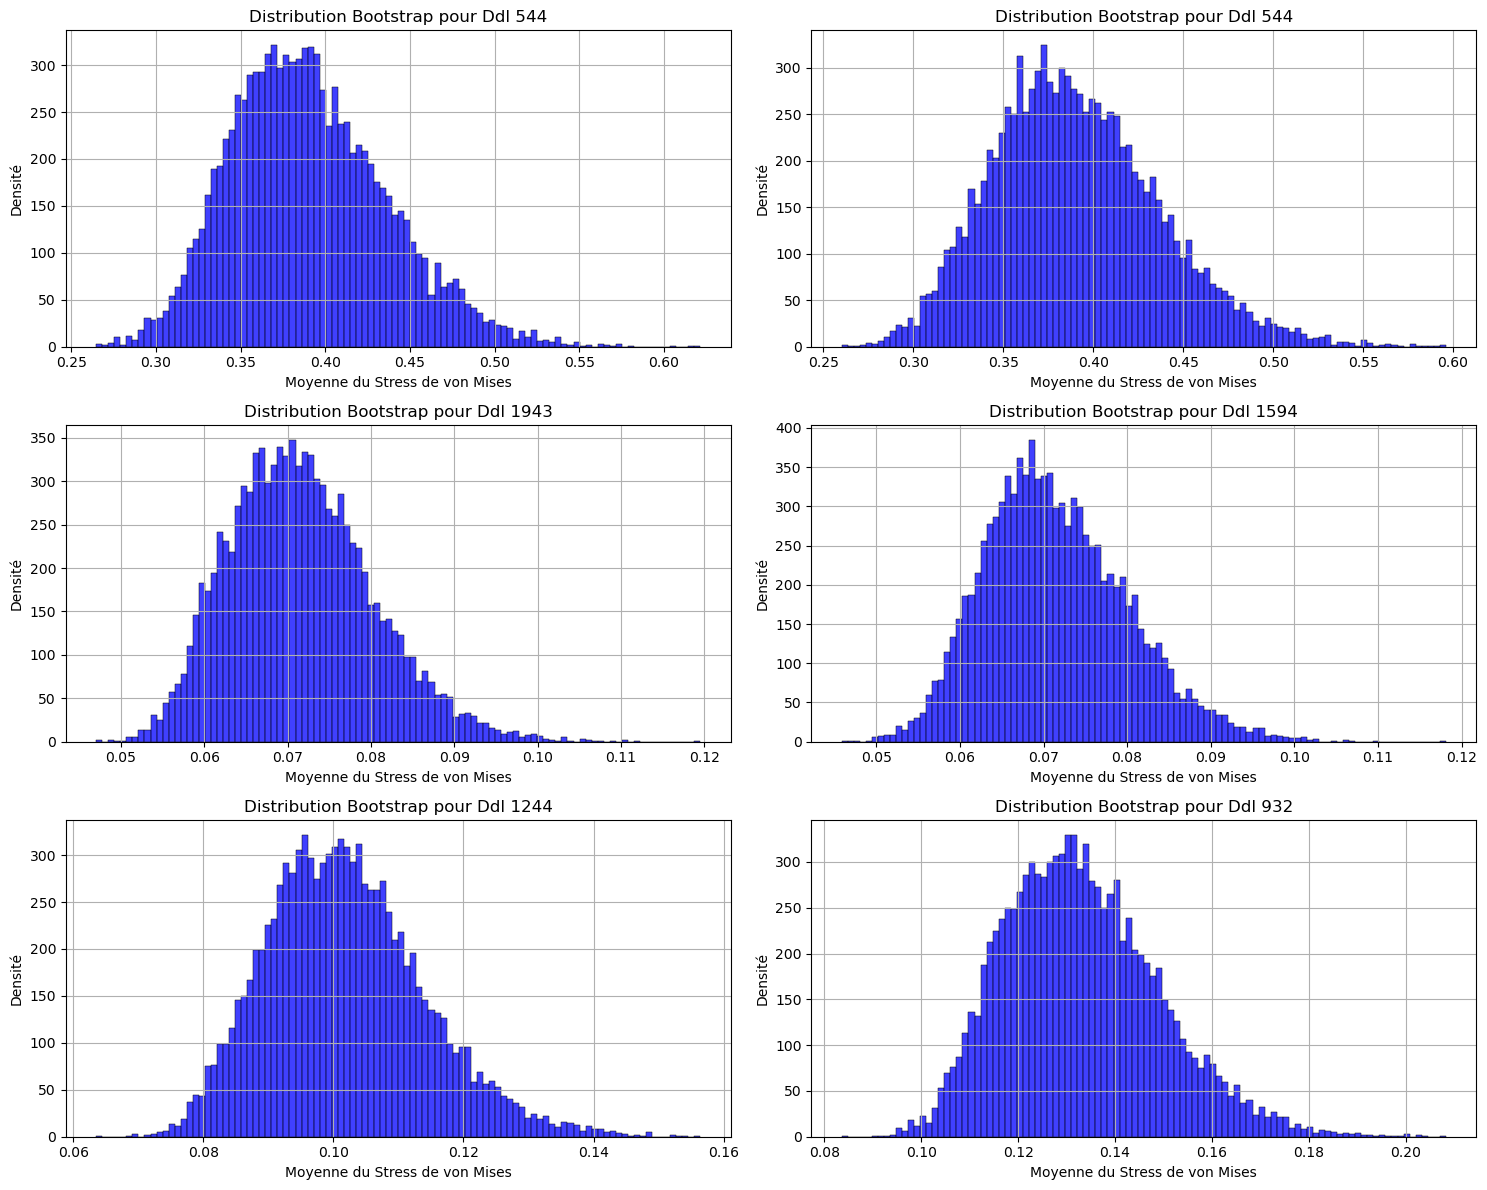

In [49]:

# Créer une figure avec 5 sous-graphes
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 lignes, 2 colonnes de sous-graphiques
axes = axes.flatten()  # Transformer en un tableau 1D pour itérer plus facilement

# Parcourir les indices et générer les graphiques bootstrap pour chacun
for idx, i in enumerate(liste_indices):
    data = []  # Pour collecter les stress sur les simulations pour le ddl i
    for j in range(test.nb_sim):  # Pour toutes les simulations
        stress_ddl = test.data_simulation(j)[1][i]  # Stress au ddl i 
        data.append(stress_ddl)

    # Convertir les données en tableau numpy
    data = np.array(data)
 
    # Générer les échantillons bootstrap
    n_resamples = 10000
    bootstrap_samples = np.random.choice(data, size=(n_resamples, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)

    # Visualiser la distribution bootstrap des moyennes
    sns.histplot(bootstrap_means, bins=100, color='blue', ax=axes[idx])
    axes[idx].set_title(f'Distribution Bootstrap pour Ddl {i}')
    axes[idx].set_xlabel('Moyenne du Stress de von Mises')
    axes[idx].set_ylabel('Densité')
    axes[idx].grid(True)

# Ajuster l'affichage des sous-graphes
plt.tight_layout()
#downloads_folder = os.path.join(os.path.expanduser('~'), 'Downloads')
#file_path = os.path.join(downloads_folder, 'ddl_dist_sqrt.png')
#plt.savefig(file_path)
#print(f"Graphique enregistré sous '{file_path}'")
plt.show()


Selon la distribution de nos données on en conclus que la methode la plus efficace sera la methode de Bootstrap-t

Affichage des resultats:

In [45]:
test.affichage_tests(0.20, 0.9)

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1baf0b52100_16&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1baf02c09d0_17&reconnect=auto" class="pyvi…

In [50]:
#maintenant, on va tester avec un niveau de confiance de 75% 

test.affichage_tests(0.20, 0.75)

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1baf1b21430_18&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:49951/index.html?ui=P_0x1bac0cb34c0_19&reconnect=auto" class="pyvi…